In [68]:
!pip install torch torchvision torchaudio
!pip install tensorflow
!pip install matplotlib
!pip install opencv-python


In [70]:
import os


image_dir = '/content/drive/MyDrive/archive (1)/img_align_celeba/img_align_celeba'


if os.path.exists(image_dir):
    print(f"Found CelebA images at {image_dir}")

    image_files = os.listdir(image_dir)
    print(image_files[:5])  # Display first 5 files
else:
    print("Directory not found. Please check the path.")


Found CelebA images at /content/drive/MyDrive/archive (1)/img_align_celeba/img_align_celeba
['002976.jpg', '002967.jpg', '002965.jpg', '002980.jpg', '002982.jpg']


In [69]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [71]:
import cv2
import numpy as np
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from glob import glob

# Define image size
image_size = 128  # Resize images to 128x128

# Load and preprocess images
images = []
image_files = glob(os.path.join(image_dir, '*.jpg'))

for img_path in image_files:
    img = load_img(img_path, target_size=(image_size, image_size))  # Resize to target size
    img_array = img_to_array(img)
    img_array = (img_array - 127.5) / 127.5  # Normalize to [-1, 1]
    images.append(img_array)

images = np.array(images)
print(f"Loaded {len(images)} images.")


Loaded 3968 images.


In [72]:
!pip install datasets transformers torch torchvision


In [73]:
dataset_path = '/content/drive/MyDrive/archive (1)/img_align_celeba/img_align_celeba'


In [74]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader


In [75]:
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])  # Normalizing to [-1, 1]
])


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [76]:
import os
dataset_path = '/content/drive/MyDrive/archive (1)/img_align_celeba/img_align_celeba'


In [77]:
!pip install torch torchvision transformers datasets huggingface_hub


In [ ]:
from huggingface_hub import notebook_login
notebook_login()


In [78]:
from huggingface_hub import Repository
repo = Repository(local_dir="celeba-gan-project", clone_from="https://huggingface.co/deeeepaaaaa/Deepaboodi")


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:131: FutureWarning: 'Repository' (from 'huggingface_hub.repository') is deprecated and will be removed from version '1.0'. Please prefer the http-based alternatives instead. Given its large adoption in legacy code, the complete removal is only planned on next major release.
For more details, please read https://huggingface.co/docs/huggingface_hub/concepts/git_vs_http.
  warnings.warn(warning_message, FutureWarning)
/content/celeba-gan-project is already a clone of https://huggingface.co/deeeepaaaaa/Deepaboodi. Make sure you pull the latest changes with `repo.git_pull()`.


In [79]:
import torch
from torchvision import datasets, transforms
import os

transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])


dataset_path = '/content/drive/MyDrive/archive (1)'


def is_valid_file(path):
    return os.path.isfile(path) and path.lower().endswith(('.jpg', '.jpeg', '.png', '.ppm', '.bmp', '.pgm', '.tif', '.tiff', '.webp')) and not os.path.basename(os.path.dirname(path)).startswith('.')

dataset = datasets.ImageFolder(root=dataset_path, transform=transform, is_valid_file=is_valid_file)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=128, shuffle=True)

In [80]:
import torch.nn as nn

class Generator(nn.Module):
    def __init__(self, latent_dim):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(latent_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 1024),
            nn.ReLU(),
            nn.Linear(1024, 64*64*3),
            nn.Tanh()
        )

    def forward(self, z):
        img = self.model(z)
        img = img.view(img.size(0), 3, 64, 64)
        return img

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64*64*3, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, img):
        validity = self.model(img)
        return validity


In [81]:
latent_dim = 100
generator = Generator(latent_dim).cuda()
discriminator = Discriminator().cuda()

optimizer_G = torch.optim.Adam(generator.parameters(), lr=0.0002)
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=0.0002)
criterion = nn.BCELoss()



In [87]:
import matplotlib.pyplot as plt

def denormalize(tensor):
    """Convert images from [-1, 1] range to [0, 1] range for visualization."""
    return (tensor + 1) / 2

def visualize_images(generator, num_images=16, latent_dim=100, device="cuda"):
    """
    Generate and display a grid of images produced by the generator.

    Args:
        generator: The trained generator model.
        num_images: Number of images to display (should be a perfect square).
        latent_dim: Dimensionality of the latent space.
        device: Device on which the generator is running (e.g., 'cuda' or 'cpu').
    """
    generator.eval()  # Set the generator to evaluation mode
    z = torch.randn(num_images, latent_dim).to(device)  # Generate random noise

    with torch.no_grad():  # No gradient computation during visualization
        generated_images = generator(z)

    # Denormalize the images for visualization
    generated_images = denormalize(generated_images.cpu())

    # Plot the images in a grid
    grid_size = int(num_images ** 0.5)  # Grid dimensions (square grid)
    fig, axes = plt.subplots(grid_size, grid_size, figsize=(8, 8))
    for i, ax in enumerate(axes.flatten()):
        if i < len(generated_images):
            ax.imshow(generated_images[i].permute(1, 2, 0).numpy())  # Convert tensor to image
            ax.axis('off')
    plt.tight_layout()
    plt.show()

    generator.train()  # Set the generator back to training mode


Epoch [1/30], d_loss: 1.0632, g_loss: 1.8086
Epoch [2/30], d_loss: 0.5269, g_loss: 1.8996
Epoch [3/30], d_loss: 0.6486, g_loss: 1.7884
Epoch [4/30], d_loss: 0.6232, g_loss: 1.8064
Epoch [5/30], d_loss: 1.0073, g_loss: 1.8399
Epoch [6/30], d_loss: 0.5157, g_loss: 1.8654
Epoch [7/30], d_loss: 0.5826, g_loss: 1.8553
Epoch [8/30], d_loss: 0.6428, g_loss: 1.8752
Epoch [9/30], d_loss: 0.3473, g_loss: 1.9041
Epoch [10/30], d_loss: 0.6653, g_loss: 1.8723


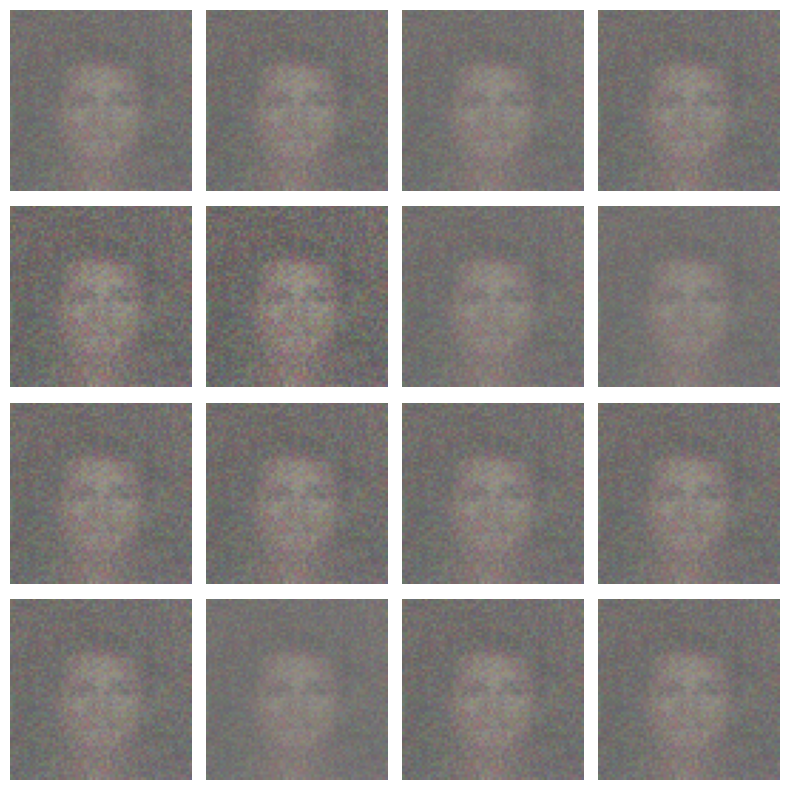

Epoch [11/30], d_loss: 0.4937, g_loss: 1.8850
Epoch [12/30], d_loss: 0.5596, g_loss: 1.9092
Epoch [13/30], d_loss: 0.4026, g_loss: 2.0135
Epoch [14/30], d_loss: 0.3247, g_loss: 1.9086
Epoch [15/30], d_loss: 0.7864, g_loss: 1.7926
Epoch [16/30], d_loss: 0.4880, g_loss: 1.7777
Epoch [17/30], d_loss: 0.6173, g_loss: 1.9187
Epoch [18/30], d_loss: 0.3667, g_loss: 1.8944
Epoch [19/30], d_loss: 0.4365, g_loss: 1.8737
Epoch [20/30], d_loss: 0.5597, g_loss: 1.8878


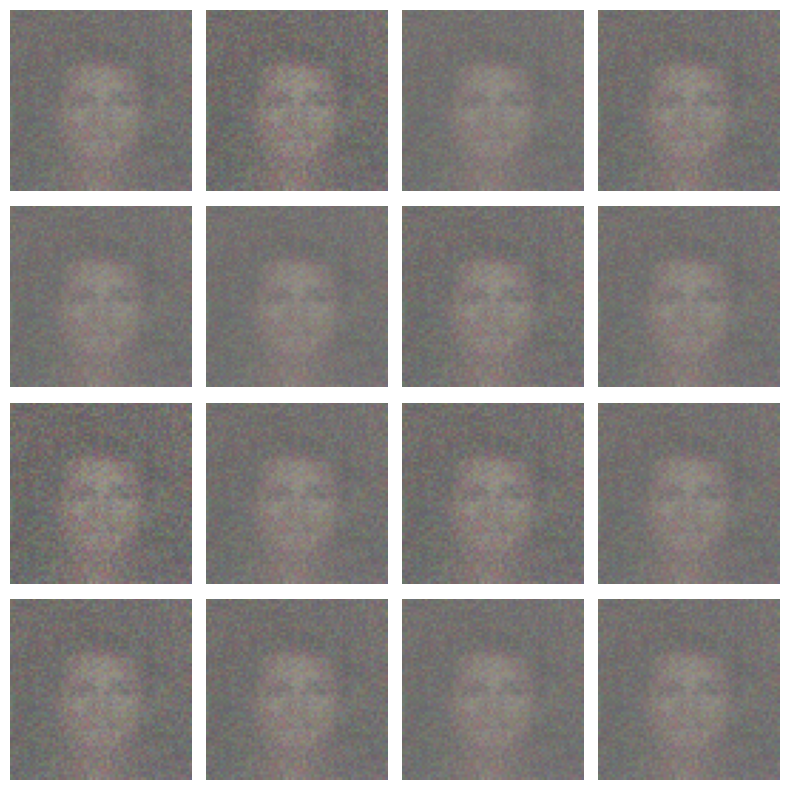

Epoch [21/30], d_loss: 0.7698, g_loss: 1.8468
Epoch [22/30], d_loss: 0.6894, g_loss: 1.7170
Epoch [23/30], d_loss: 0.5168, g_loss: 1.9874
Epoch [24/30], d_loss: 0.5188, g_loss: 1.8721
Epoch [25/30], d_loss: 0.6016, g_loss: 1.8271
Epoch [26/30], d_loss: 0.5145, g_loss: 1.8413
Epoch [27/30], d_loss: 0.5662, g_loss: 1.8702
Epoch [28/30], d_loss: 0.4207, g_loss: 1.8637
Epoch [29/30], d_loss: 0.6169, g_loss: 1.8248
Epoch [30/30], d_loss: 0.6962, g_loss: 1.9021


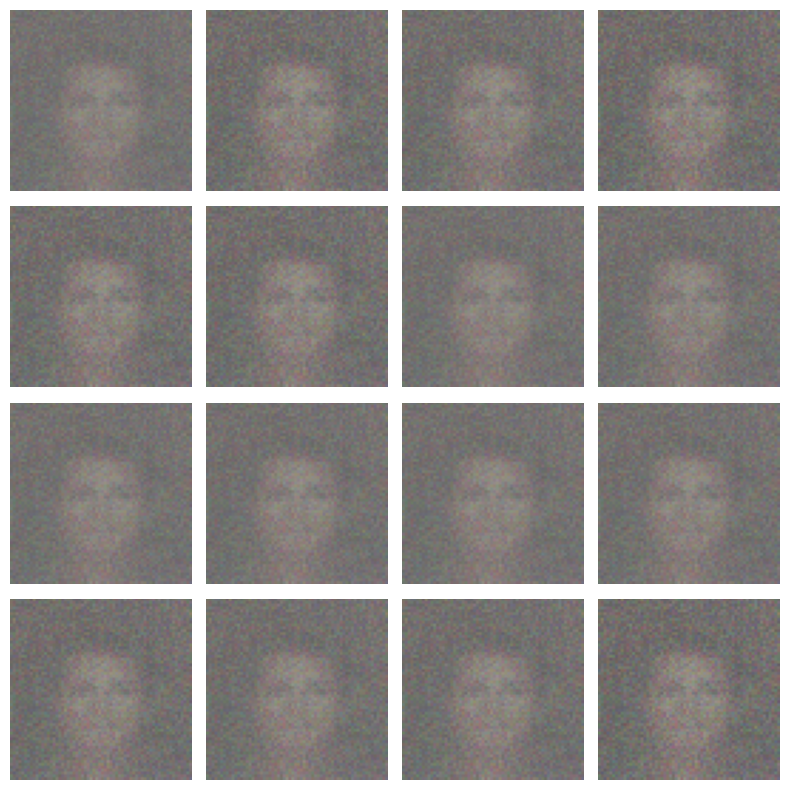

In [88]:
# Define training parameters
num_epochs = 30  # Number of epochs
g_steps = 2  # Number of generator training steps per discriminator step

for epoch in range(num_epochs):
    for i, (real_images, _) in enumerate(dataloader):
        real_images = real_images.to(device)

        # === Train the Discriminator ===
        optimizer_d.zero_grad()

        # Real images loss
        output_real = discriminator(real_images)
        loss_real = criterion(output_real, real_labels)

        # Fake images loss
        z = torch.randn(batch_size, latent_dim).to(device)
        fake_images = generator(z)
        output_fake = discriminator(fake_images.detach())  # Detach to avoid backprop through the generator
        loss_fake = criterion(output_fake, fake_labels)

        # Total discriminator loss
        d_loss = loss_real + loss_fake
        d_loss.backward()
        optimizer_d.step()

        # === Train the Generator ===
        for _ in range(g_steps):  # Train generator multiple times
            optimizer_g.zero_grad()

            # Generator loss
            z = torch.randn(batch_size, latent_dim).to(device)
            fake_images = generator(z)
            output_fake = discriminator(fake_images)  # No detach, as we want backprop through generator
            g_loss = criterion(output_fake, real_labels)  # Fool the discriminator

            g_loss.backward()
            optimizer_g.step()

    # Print loss values
    print(f"Epoch [{epoch+1}/{num_epochs}], d_loss: {d_loss.item():.4f}, g_loss: {g_loss.item():.4f}")

    # Visualize generated images every few epochs
    if (epoch + 1) % 10 == 0:  # Visualize every 10 epochs
        visualize_images(generator, num_images=16, latent_dim=latent_dim, device=device)


In [83]:
torch.save(generator.state_dict(), "celeba-gan-project/generator.pth")
torch.save(discriminator.state_dict(), "celeba-gan-project/discriminator.pth")


In [ ]:
!git config --global user.email "boodideepa@gmial.com"
!git config --global user.name "deeeepaaaaa"
repo.push_to_hub()

In [ ]:
from huggingface_hub import notebook_login


notebook_login()

repo.push_to_hub()

<ipython-input-89-c5b29dc04ad5>:37: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  generator.load_state_dict(torch.load("celeba-gan-project/generator.pth"))


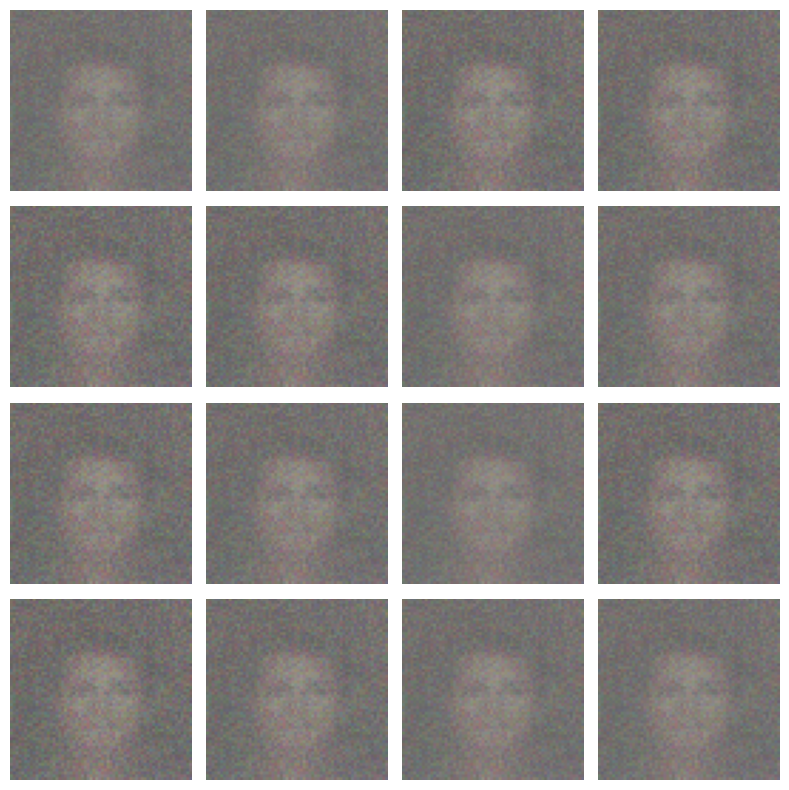

In [89]:
import matplotlib.pyplot as plt
import torch

# Function to denormalize images from [-1, 1] to [0, 1] for visualization
def denormalize(tensor):
    return (tensor + 1) / 2

# Function to generate and visualize images
def visualize_generated_images(generator, num_images=16, latent_dim=100, device="cuda"):
    # Ensure the generator is in evaluation mode
    generator.eval()

    # Generate random noise as input for the generator
    z = torch.randn(num_images, latent_dim).to(device)
  # Generates random noise for each image

    # Generate images using the generator
    with torch.no_grad():
        generated_images = generator(z)

    # Move images to CPU and denormalize for visualization
    generated_images = denormalize(generated_images.cpu())

    # Plot the generated images
    fig, axes = plt.subplots(4, 4, figsize=(8, 8))
    for i, ax in enumerate(axes.flatten()):
        if i < num_images:
            # Convert tensor to numpy array and display as an image
            ax.imshow(generated_images[i].permute(1, 2, 0).numpy())
            ax.axis('off')
    plt.tight_layout()
    plt.show()

# Load the generator weights (adjust path as needed)
latent_dim = 100
generator = Generator(latent_dim).cuda()  # Ensure your generator is properly defined elsewhere
generator.load_state_dict(torch.load("celeba-gan-project/generator.pth"))
generator.to("cuda")

# Visualize generated images
visualize_generated_images(generator, num_images=16, latent_dim=latent_dim, device="cuda")


In [91]:
def calculate_inception_score(generator, latent_dim, num_images, device="cuda", batch_size=32):
    """
    Calculate the Inception Score (IS) for a GAN.

    Args:
        generator: The trained generator model.
        latent_dim: Dimensionality of the latent space.
        num_images: Number of images to evaluate.
        device: Device ('cuda' or 'cpu').
        batch_size: Number of images to process at a time.
    Returns:
        IS score.
    """
    inception_model = inception_v3(weights="DEFAULT", transform_input=False).to(device)
    inception_model.eval()

    preds = []
    for i in range(0, num_images, batch_size):
        z = torch.randn(min(batch_size, num_images - i), latent_dim).to(device)
        with torch.no_grad():
            generated_images = generator(z).to(device)
        generated_images = (generated_images + 1) / 2  # Normalize to [0, 1]
        generated_images = F.interpolate(generated_images, size=(299, 299), mode='bilinear', align_corners=False)

        with torch.no_grad():
            batch_preds = F.softmax(inception_model(generated_images), dim=1).cpu().numpy()
            preds.append(batch_preds)

    preds = np.concatenate(preds, axis=0)
    p_y = np.mean(preds, axis=0)
    kl_div = preds * (np.log(preds) - np.log(p_y))
    is_score = np.exp(np.mean(np.sum(kl_div, axis=1)))
    return is_score

# Example usage
is_score = calculate_inception_score(generator, latent_dim=100, num_images=1000, device="cuda", batch_size=32)
print(f"Inception Score: {is_score}")


Inception Score: 1.0250118970870972


In [94]:
import torch
torch.cuda.empty_cache()
